# Start: loading the necessary packages

In [2]:
# make sure matplotlib shows images inline
%matplotlib inline

# import packages
import numpy as np
import time
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import os
import cv2
import random
import pickle
from PIL import Image

# Keras packages
from keras import layers
from keras import optimizers
from keras.layers import Input,Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.initializers import glorot_uniform

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import keras.backend as K

In [3]:
current_directory = os.getcwd()

os.chdir(current_directory)

print(current_directory)

C:\GitHub\HandSign_Recognition


# Define some functions we'll use later in the script
* read images 
* resize images

ATTENTION: all images should have the same aspect ratio and the same orientation (either all landscape OR all portrait)

In [4]:
# define a function that reads images from a location and uses the image names as labels
def read_images(imgloc = ''):
    # read all images from file into a numpy array
    # cv2 assumes colors are BGR, so we also convert this to RGB
    images = np.array([cv2.cvtColor(cv2.imread(imgloc + name), cv2.COLOR_BGR2RGB) 
                       for name in os.listdir(imgloc)], dtype = np.object)

    # use the image names to create a numpy array with the label of each image
    labels  = np.array([str(name.rpartition(' ')[0].rpartition('_')[2]) for name in os.listdir(imgloc)])
    
    return images, labels

def resize_images(img, basewidth = 64, set_grayscale = False, binarize = False, binarize_min = 135, binarize_max = 255):
    # make sure the numpy array contains integers (otherwise we can't convert them to PIL images)
    img = img.astype('uint8')
    #plt.imshow(img)
    
    # convert the numpy array image to PIL image
    img = Image.fromarray(img)
    #print(type(img))

    # calculate the height, based on the preferred width
    hsize = int((float(img.size[1]) * float((basewidth / float(img.size[0])))))
    #print(hsize)

    # resize the image
    img = img.resize((basewidth,hsize), Image.ANTIALIAS)
    #print(img.size)
    #plt.imshow(img)
    
    # convert image to grayscale if parameter is True
    if set_grayscale:
        img = img.convert("L")
           
    # convert the image to numpy array
    img = np.array(img)
    #print(type(img))
    
    # binarize image if parameter is True
    if binarize:
        thr, img = cv2.threshold(img, binarize_min, binarize_max, cv2.THRESH_BINARY)
    
    # if image is converted to grayscale, make sure to set the channels shape parameter
    if set_grayscale:
        img = img.reshape((img.shape[0], img.shape[1], 1))
    
    return img

# Read images
Load all the images we want to use to train and evaluate the model

In [5]:
# print the current datetime
print('start: ', str(time.ctime()), '\n')
start = time.time()

# read the training data
imgloc = current_directory + '/00 Data/TRAIN/'
train_img, train_label = read_images(imgloc)

# print the current datetime
print('finish: ', str(time.ctime()), '\n')
print("this took --- %s seconds ---" % round(time.time() - start, 2))

start:  Tue Mar 20 15:15:29 2018 

finish:  Tue Mar 20 15:15:49 2018 

this took --- 20.41 seconds ---


In [6]:
# print the current datetime
print('start: ', str(time.ctime()), '\n')
start = time.time()

# read the test data
imgloc = current_directory + '/00 Data/TEST/'
test_img, test_label = read_images(imgloc)

# print the current datetime
print('finish: ', str(time.ctime()), '\n')
print("this took --- %s seconds ---" % round(time.time() - start, 2))

start:  Tue Mar 20 15:15:49 2018 

finish:  Tue Mar 20 15:15:51 2018 

this took --- 1.72 seconds ---


In [7]:
# Read the handsign dataset
#train_dataset = h5py.File('00 Data/train_signs.h5', "r")
#train_img = np.array(train_dataset["train_set_x"][:]) # your train set features
#train_label = np.array(train_dataset["train_set_y"][:]) # your train set labels

#test_dataset = h5py.File('00 Data/test_signs.h5', "r")
#test_img = np.array(test_dataset["test_set_x"][:]) # your test set features
#test_label = np.array(test_dataset["test_set_y"][:]) # your test set labels

In [8]:
print(train_img.shape)
print(train_label.shape)
print(train_label)

print('\n')

print(test_img.shape)
print(test_label.shape)
print(test_label)

(36, 3968, 2976, 3)
(36,)
['B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'C' 'C' 'C' 'C' 'C' 'C'
 'C' 'C' 'C' 'C' 'C' 'C' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D']


(3, 3968, 2976, 3)
(3,)
['B' 'C' 'D']


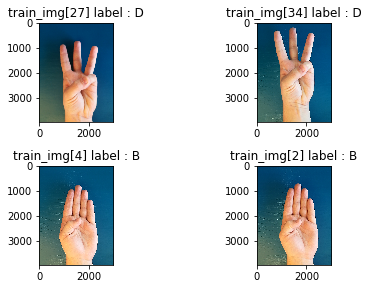

In [9]:
# let's take a look at some of the images (train)

# randomly pick 4 of the images
samp = random.sample(range(0,len(train_img)-1),4)

plt.subplots(2,2)
plt.subplots_adjust(top = 0.92, bottom = 0.08, left = 0.10, right = 0.95, hspace = 0.45, wspace = 0.45)

plt.subplot(2,2,1)
plt.title('train_img[' + str(samp[0]) + '] label : ' + str(train_label[samp[0]]))
plt.imshow(train_img[samp[0]].astype('uint8'))

plt.subplot(2,2,2)
plt.title('train_img[' + str(samp[1]) + '] label : ' + str(train_label[samp[1]]))
plt.imshow(train_img[samp[1]].astype('uint8'))

plt.subplot(2,2,3)
plt.title('train_img[' + str(samp[2]) + '] label : ' + str(train_label[samp[2]]))
plt.imshow(train_img[samp[2]].astype('uint8'))

plt.subplot(2,2,4)
plt.title('train_img[' + str(samp[3]) + '] label : ' + str(train_label[samp[3]]))
plt.imshow(train_img[samp[3]].astype('uint8'))

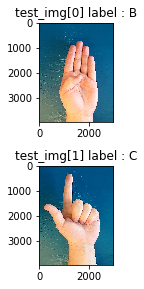

In [10]:
# let's take a look at some of the images (test)

# randomly pick 2 of the images
samp = random.sample(range(0,len(test_img)-1),2)

plt.subplots(2,1)
plt.subplots_adjust(top = 0.92, bottom = 0.08, left = 0.10, right = 0.95, hspace = 0.45, wspace = 0.45)

plt.subplot(2,1,1)
plt.title('test_img[' + str(samp[0]) + '] label : ' + str(test_label[samp[0]]))
plt.imshow(test_img[samp[0]].astype('uint8'))

plt.subplot(2,1,2)
plt.title('test_img[' + str(samp[1]) + '] label : ' + str(test_label[samp[1]]))
plt.imshow(test_img[samp[1]].astype('uint8'))

# Resize images
It doesn't matter which size the images are at the start, we'll try to scale them down here for the sake of efficiency

In [11]:
# set the parameter that decides if images should be converted to grayscale
set_img_grayscale = True

# set the parameter that decides if images should be binarized (black/white)
# and set the binarize boundaries
binarize = False
binarize_min = 135
binarize_max = 255

In [12]:
# print the current datetime
print('start: ', str(time.ctime()), '\n')
start = time.time()

# resize the images
basewidth = 64
img_list = []

# loop through all the images in the data and resize them
for img in train_img:
    # resize the numpy array images
    img = resize_images(img, basewidth, set_img_grayscale, binarize, binarize_min, binarize_max)
    # add the image to a list of numpy array images
    img_list.append(img)

#print(img_list)
    
# print the current datetime
print('finish: ', str(time.ctime()), '\n')
print("this took --- %s seconds ---" % round(time.time() - start, 2))

start:  Tue Mar 20 15:16:00 2018 

finish:  Tue Mar 20 15:16:34 2018 

this took --- 34.09 seconds ---


In [13]:
# convert the list with images back to a numpy array
train_img = np.array(img_list)
print(train_img.shape)

(36, 85, 64, 1)


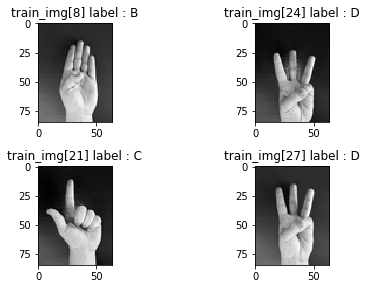

In [14]:
# let's take a look at some of the images (train)

# randomly pick 4 of the images
samp = random.sample(range(0,len(train_img)-1),4)

plt.subplots(2,2)
plt.subplots_adjust(top = 0.92, bottom = 0.08, left = 0.10, right = 0.95, hspace = 0.45, wspace = 0.45)

plt.subplot(2,2,1)
plt.title('train_img[' + str(samp[0]) + '] label : ' + str(train_label[samp[0]]))
if set_img_grayscale:
    plt.imshow(train_img[samp[0]].squeeze(), cmap = 'gray')
else:
    plt.imshow(train_img[samp[0]])

plt.subplot(2,2,2)
plt.title('train_img[' + str(samp[1]) + '] label : ' + str(train_label[samp[1]]))
if set_img_grayscale:
    plt.imshow(train_img[samp[1]].squeeze(), cmap = 'gray')
else:
    plt.imshow(train_img[samp[1]])

plt.subplot(2,2,3)
plt.title('train_img[' + str(samp[2]) + '] label : ' + str(train_label[samp[2]]))
if set_img_grayscale:
    plt.imshow(train_img[samp[2]].squeeze(), cmap = 'gray')
else:
    plt.imshow(train_img[samp[2]])

plt.subplot(2,2,4)
plt.title('train_img[' + str(samp[3]) + '] label : ' + str(train_label[samp[3]]))
if set_img_grayscale:
    plt.imshow(train_img[samp[3]].squeeze(), cmap = 'gray')
else:
    plt.imshow(train_img[samp[3]])

In [15]:
# print the current datetime
print('start: ', str(time.ctime()), '\n')
start = time.time()

# resize the images
basewidth = 64
img_list = []

# loop through all the images in the data and resize them
for img in test_img:
    # resize the numpy array images
    img = resize_images(img, basewidth, set_img_grayscale)
    # add the image to a list of numpy array images
    img_list.append(img)

#print(img_list)
    
# print the current datetime
print('finish: ', str(time.ctime()), '\n')
print("this took --- %s seconds ---" % round(time.time() - start, 2))

start:  Tue Mar 20 15:16:38 2018 

finish:  Tue Mar 20 15:16:41 2018 

this took --- 2.83 seconds ---


In [16]:
# convert the list with images back to a numpy array
test_img = np.array(img_list)
print(test_img.shape)

(3, 85, 64, 1)


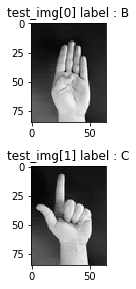

In [17]:
# let's take a look at some of the images (test)

# randomly pick 2 of the images
samp = random.sample(range(0,len(test_img)-1),2)

plt.subplots(2,1)
plt.subplots_adjust(top = 0.92, bottom = 0.08, left = 0.10, right = 0.95, hspace = 0.45, wspace = 0.45)

plt.subplot(2,1,1)
plt.title('test_img[' + str(samp[0]) + '] label : ' + str(test_label[samp[0]]))
if set_img_grayscale:
    plt.imshow(test_img[samp[0]].squeeze(), cmap = 'gray')
else:
    plt.imshow(test_img[samp[0]])

plt.subplot(2,1,2)
plt.title('test_img[' + str(samp[1]) + '] label : ' + str(test_label[samp[1]]))
if set_img_grayscale:
    plt.imshow(test_img[samp[1]].squeeze(), cmap = 'gray')
else:
    plt.imshow(test_img[samp[1]])

In [18]:
# normalize the data

#print(train_img[1])
train_img = train_img / 255
#print(train_img[1])

#print(test_img[1])
test_img = test_img / 255
#print(test_img[1])

# Label matrix: one hot encoding
The model needs a matrix where:
* the number of records = the number of images
* the number of columns = the number of possible values (labels) the images can represent

in this matrix all values will be 0 except for the column where the label is the label that specific image represents, there the value will be 1

In [20]:
# determine the number of unique labels
nr_possible_values = np.unique(train_label).size #40
#print(nr_possible_values)

# create a matrice with only zeros
# the number of rows = the number of images
# the number of columns = the number of possible values we want to recognize
label_matrix_train = np.zeros([train_label.shape[0], nr_possible_values])
label_matrix_test = np.zeros([test_label.shape[0], nr_possible_values])
#print(label_matrix_train)
#print(label_matrix_test)

# create a dictionary for the labels
# we're going to use this dictionary to determine which column in the matrix corresponds to which value
#label_dict = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9
#              , 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19
#              , 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'SPATIE': 26, 'PUNT': 27, 'STREEPJE': 28, '@': 29
#              , '1': 30, '2': 31, '3': 32, '4': 33, '5': 34, '6': 35, '7': 36, '8': 37, '9': 38, '0': 39}

#label_dict = {'0':0, '1':1, '2':2, '3':3, '4':4, '5':5}
label_dict = {'B':0, 'C':1, 'D':2}

# save the dictionary to file
pickle.dump(label_dict, open(current_directory + '/01 Models/LabelDictionary.pkl', 'wb'), pickle.HIGHEST_PROTOCOL)

# set the value of 1 for each record in the column with the corresponding value
count = 0
for i in train_label:
    label_matrix_train[count, label_dict[str(i)]] = 1
    count = count + 1

# set the value of 1 for each record in the column with the corresponding value
count = 0
for i in test_label:
    label_matrix_test[count, label_dict[str(i)]] = 1
    count = count + 1

#print(train_label)
#print(label_matrix_train)
print(test_label)
print(label_matrix_test)

['B' 'C' 'D']
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]


# Prepare the model
* define variables
* define funtions

In [21]:
# make sure to tell keras the channels are the last dimension in the shape of the dataset
# full color RGB image = 3 channels
# grayscale image = 1 channel
K.set_image_data_format('channels_last')


def plain_layer(X,n_c):
    X_in = X
    X = Conv2D(n_c,kernel_size = (3,3), padding = 'same')(X_in)
    X = BatchNormalization(axis = 3, momentum = .01)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size = (2,2))(X)
    return X


def identity_block(X,F):
    X_in = X
    
    F1,F2,F3 = F
    
    X = Conv2D(F1,kernel_size = (3,3), padding= 'same')(X_in)
    X = BatchNormalization(axis = 3, momentum = .01)(X)
    X = Activation('relu')(X)
    
    #X = Conv2D(F2,kernel_size = (3,3), padding = 'same')(X)
    #X = BatchNormalization(axis = 3, momentum = .01)(X)
    #X = Activation('relu')(X)
    
    X = Conv2D(F3,kernel_size = (3,3), padding = 'same')(X)
    X = BatchNormalization(axis = 3, momentum = .01)(X)
    
    X_in = Conv2D(F3,kernel_size = (3,3), padding = 'same')(X_in)
    X_in = BatchNormalization(axis = 3, momentum = .01)(X_in)
    
    X = Add()([X,X_in])
    X = Activation('relu')(X)
    
    return X


def Resnet(input_shape = (85,64,3), classes = 6):
    X_in = Input(input_shape)
    
    X = plain_layer(X_in,32)
    
    F1 = [16,16,32]
    X = identity_block(X,F1)
    X = MaxPooling2D(pool_size = (2,2))(X)
    
    #F2 = [16,16,32]
    #X = identity_block(X,F2)
    #X = MaxPooling2D(pool_size = (2,2))(X)
    
    #F3 = [16,16,32]
    #X = identity_block(X,F3)
    #X = MaxPooling2D(pool_size = (2,2))(X)
    
    X = plain_layer(X,32)
    X = AveragePooling2D((2,2))(X)
    
    X = Flatten()(X)
    X = Dense(512,activation='relu')(X)
    X = Dense(128,activation='relu')(X)
    X = Dense(classes,activation='softmax')(X)
    
    model = Model(inputs = X_in, outputs = X, name = 'Resnet')
    return model

# Train the model

In [22]:
# https://machinelearningmastery.com/image-augmentation-deep-learning-keras/

print("start: define data generator")
# define data preparation
datagen = image.ImageDataGenerator(rescale = None #1/255 # normalize the data
                                   , rotation_range = 20 # degree range for random rotations
                                   , width_shift_range = 0.2 # range for random horizontal shifts
                                   , height_shift_range = 0.2 # range for random vertical shifts
                                   , shear_range = 0.2 # shear angle in counter-clockwise direction as radians
                                   , zoom_range = 0.2 # Range for random zoom
                                   , horizontal_flip = False # flip horizontally
                                   , vertical_flip = False # flip vertically
                                   , fill_mode = "nearest"
                                  )

print("start: fit parameters from data")
# fit parameters from data
datagen.fit(train_img)    

start: define data generator
start: fit parameters from data


In [23]:
# determine the shape of the images
img_shape = train_img.shape[1:4]

# declare a resnet model
my_model = Resnet(input_shape = img_shape, classes = nr_possible_values)


# define the training parameters: nr of epochs
nr_ep = 20

# define the training parameters: batch size
btch_sz = min(int(len(train_img) / 2), 32)

# define the training parameters: steps per epoch
stps = int(len(train_img) / btch_sz)

# define the training parameters: optimizer function
opt = 'adam'

# define the training parameters: loss function
loss = 'categorical_crossentropy'


# set the parameters for the model
my_model.compile(optimizer = opt, loss = loss, metrics = ['accuracy'])

In [ ]:

# print the current date and time
start = time.time()
print('start: ', str(time.ctime()), '\n')

# print some of the input parameters
print("the batch_size is " + str(btch_sz) + ", the number of steps_per_epoch is " + 
      str(stps) + " and the number of epochs is " + str(nr_ep) + '\n')

# train the model
# my_model.fit(x = train_img_norm, y = label_matrix_train, epochs = nr_ep, batch_size = btch_sz)

# train the model with the datagenerator images
my_model.fit_generator(datagen.flow(train_img, label_matrix_train, batch_size = btch_sz
                                   # , save_to_dir='images', save_prefix='aug', save_format='png'
                                   ), steps_per_epoch = stps, epochs = nr_ep)

# print the current date and time
print('\n', 'finish: ', str(time.ctime()), '\n')
print("this took --- %s seconds ---" % round(time.time() - start, 2))

time.sleep(5)

# Evaluate the model

In [ ]:
# evaluate the model on the training data
eval_my_model = my_model.evaluate(train_img, label_matrix_train, batch_size = btch_sz)

print("The accuracy of this model is: " + str(round(eval_my_model[1]*100, 2)) + "%")

In [ ]:
# evaluate the model on the training data
#eval_my_model = my_model.evaluate(train_img, label_matrix_train, batch_size = None, steps = 100)

print("The accuracy of this model is: " + str(round(eval_my_model[1]*100, 2)) + "%")

In [ ]:
pred = my_model.predict_generator(datagen.flow(test_img, label_matrix_test, batch_size = len(test_img)
                                   # , save_to_dir='images', save_prefix='aug', save_format='png'
                                   ))

thresh = .4
resulting_labels = []

for i in range(0, pred.shape[0]):
   
    single_pred = pred[i]
    print('\n the prediction matrix:')
    print(single_pred)
    
    # set all elements below the threshold to zero
    single_pred[single_pred < thresh] = 0
    print('\n the cleaned prediction matrix:')
    print(single_pred)
    
    # if matrix contains all zeros, no prediction can be done
    if np.any(single_pred):
        print("\n prediction can be done")
        
        # check which column contains the highest probability
        resulting_labels.append(list(label_dict.keys())[list(label_dict.values()).index(np.argmax(single_pred))])
        
    else:
        print("\n no prediction possible")
        resulting_labels.append("Unknown")
    
    #print('\n')


print('\n The labels according to the prediction:')
print(resulting_labels)
print('\n The labels according to the testset:')
print(test_label)

# create a classification report
print(classification_report(test_label.astype(str), resulting_labels))

# Save the model to disk
This way we can use the model on other computers

In [ ]:
# location to save the model
imgloc = current_directory + '/01 Models/'

# serialize model to JSON and save it
my_model_json = my_model.to_json()
with open(imgloc + "my_model.json", "w") as json_file:
    json_file.write(my_model_json)

# serialize weights to HDF5
my_model.save_weights(imgloc + "my_model.h5")
print("Saved model to disk")

In [ ]:
# https://sandipanweb.wordpress.com/2018/01/20/hand-gesture-classification-using-deep-convolution-and-residual-neural-network-with-tensorflow-keras-in-python/

In [24]:
# hoe nog verder optimaliseren / ander model?
# layers er tussenuit
# xgboost
# fast.AI - our mooc

In [25]:
import xgboost as xgb

In [26]:
# create a function which makes an array from a matrix
def im_to_wide(grey):
    y = []
    for r in range(0,len(grey)):
        for col in range(0,len(grey[r])):
            y.append(grey[r][col])
    return y
            
def wide_to_im(x, size):
    if size[0] * size[1] != len(x):
        print('Size does not match')
        raise

    x = np.array(x)
    x.shape = size

    im = Image.fromarray(x)

    return im

In [27]:
# create an array from the image matrix
train_img_arr  = np.array([im_to_wide(im) for im in train_img])
test_img_arr = np.array([im_to_wide(im) for im in test_img])

# remove the last dimension of the array, to make sure it's a 2D array
train_img_arr = train_img_arr[:,:,0]
test_img_arr = test_img_arr[:,:,0]

In [28]:
# print the current date and time
start = time.time()
print('start: ', str(time.ctime()), '\n')

xb = xgb.XGBClassifier(n_estimators = 500, objective = 'multi:softprob')
xgb_model = xb.fit(train_img_arr, train_label)

print(xgb_model)

# print the current date and time
print('\n', 'finish: ', str(time.ctime()), '\n')
print("this took --- %s seconds ---" % round(time.time() - start, 2))

start:  Tue Mar 20 15:27:17 2018 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

 finish:  Tue Mar 20 15:27:26 2018 

this took --- 8.61 seconds ---


In [29]:
modprob = xgb_model.predict_proba(test_img_arr)
print(modprob.shape)
print(modprob)

(3, 3)
[[ 0.02111677  0.95776647  0.02111677]
 [ 0.02111677  0.95776647  0.02111677]
 [ 0.02111677  0.02111677  0.95776647]]


In [30]:
xb.classes_

array(['B', 'C', 'D'],
      dtype='<U1')

In [31]:
thresh = .4
resulting_labels = []

for i in range(0, modprob.shape[0]):
   
    single_pred = modprob[i]
    print('\n the prediction matrix:')
    print(single_pred)
    
    # set all elements below the threshold to zero
    single_pred[single_pred < thresh] = 0
    print('\n the cleaned prediction matrix:')
    print(single_pred)
    
    # if matrix contains all zeros, no prediction can be done
    if np.any(single_pred):
        print("\n prediction can be done")
        
        # check which column contains the highest probability
        resulting_labels.append(list(label_dict.keys())[list(label_dict.values()).index(np.argmax(single_pred))])
        
    else:
        print("\n no prediction possible")
        resulting_labels.append("Unknown")
    
    #print('\n')


print('\n The labels according to the prediction:')
print(resulting_labels)
print('\n The labels according to the testset:')
print(test_label)

# create a classification report
print(classification_report(test_label.astype(str), resulting_labels))


 the prediction matrix:
[ 0.02111677  0.95776647  0.02111677]

 the cleaned prediction matrix:
[ 0.          0.95776647  0.        ]

 prediction can be done

 the prediction matrix:
[ 0.02111677  0.95776647  0.02111677]

 the cleaned prediction matrix:
[ 0.          0.95776647  0.        ]

 prediction can be done

 the prediction matrix:
[ 0.02111677  0.02111677  0.95776647]

 the cleaned prediction matrix:
[ 0.          0.          0.95776647]

 prediction can be done

 The labels according to the prediction:
['C', 'C', 'D']

 The labels according to the testset:
['B' 'C' 'D']
             precision    recall  f1-score   support

          B       0.00      0.00      0.00         1
          C       0.50      1.00      0.67         1
          D       1.00      1.00      1.00         1

avg / total       0.50      0.67      0.56         3



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
